# Práctica Machine Learning

## Segunda Iteración

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc
import pickle
import datetime
import random

C:\Users\MARIO\anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


### Datos

In [2]:
with open('benchmark_data.pkl', 'rb') as handle:
    bm = pickle.load(handle)
ibex = bm['ibex']
ibex

,close,high,low,open,vol
2000-01-03,11610.0,11881.8,11574.4,11846.6,60107000.0
2000-01-04,11206.6,11530.0,11159.8,11499.5,62539000.0
2000-01-05,10863.1,11068.1,10824.9,11206.6,68153000.0
2000-01-07,11102.4,11137.9,10882.7,10963.4,144207000.0
2000-01-10,11173.3,11364.3,11120.6,11363.8,133817000.0
...,...,...,...,...,...
2019-06-04,9117.6,9138.5,8964.2,8972.7,197017094.0
2019-06-05,9150.5,9173.4,9095.0,9136.8,158753002.0
2019-06-06,9169.2,9246.2,9136.7,9169.2,212720881.0
2019-06-07,9236.1,9261.4,9185.7,9186.7,150664687.0


### Bucle etiquetado

Se ha creado un nuevo bucle de etiquetado a partir del de la iteración 1 puesto que esta vez el problema es multiclase. El bucle funciona de la misma forma que el anterior pero en este caso se tienen 3 etiquetas distintas correspondientes a tres patrones: doble suelo, doble techo y sin patrón. El bucle funciona de la misma forma

In [3]:
def bucle_etiquetado (n,window):
    etiquetas = np.zeros(n)
    idfechas = np.zeros(n)
    for i in range(n):
        idx = np.random.randint(0, ibex.shape[0] - window)
        idfechas[i] = idx
        windata = ibex.iloc[idx:idx+window]
        fig, ax = plt.subplots(figsize=(6,4))
        _ = candlestick2_ohlc(ax, windata.open, windata.high,
                             windata.low, windata.close,
                             colorup='g', colordown='r', width=0.66, alpha=0.8)
        plt.show()
        print(f'Ejemplo {i+1} de {n}')
        print("Etiquete la siguiete grafica como:")
        print(" [1] Doble suelo, [0] Sin patrón,[2] Doble techo, [3] Descartar ejemplo")
        opcion_usuario = input()
        if opcion_usuario >= '0' and opcion_usuario <= '3':
            etiquetas[i] = opcion_usuario   
        else:
            print('Error en la opción introducida. Ejemplo descartado')
            etiquetas[i] = 2
    doble_suelo_labels = pd.Series(etiquetas, index=ibex.index[idfechas.astype(int)])
    doble_suelo_labels = doble_suelo_labels[doble_suelo_labels!=3]
    doble_suelo_labels = pd.DataFrame(doble_suelo_labels).reset_index()
    doble_suelo_labels.columns = ['fecha','etiqueta']
    return doble_suelo_labels

### Características

Retorno de los datos en dicha ventana

In [4]:
def retorno_ventana(data):
    r = data.close.iloc[-1]/data.close.iloc[0] - 1
    return r 

Número de días que pasan entre el máximo y el mínimo de la ventana

In [5]:
def dif_dias_max_min (data):
    
    dia_max = data["close"][data["close"] == data["close"].max()].index[0]
    dia_min = data["close"][data["close"] == data["close"].min()].index[0]
    dif_dias = dia_max - dia_min
    return abs(dif_dias.days)

Número de veces en la ventana que cruza un umbral inferior

In [6]:
def cruce_umbral (data,porcent_umbral = 0.1):
    
    precio_min = data["close"][data["close"] == data["close"].min()].values
    precio_max = data["close"][data["close"] == data["close"].max()].values
    umbral = precio_min + porcent_umbral*(precio_max-precio_min)
    n_datos_inf_umbral = data.close[data.close <= umbral[0]].shape[0]
    return n_datos_inf_umbral

Orden del máximo y el mínimo (cual ocurre primero)

In [7]:
def orden_max_min (data):
    
    dia_max = data["close"][data["close"] == data["close"].max()].index[0]
    dia_min = data["close"][data["close"] == data["close"].min()].index[0]
    
    if dia_max > dia_min :
        etiqueta = 1
    else:
        etiqueta = 0
    
    return etiqueta

Número de veces en la ventana que cruza un umbral superior

In [8]:
def cruce_umbral2 (data,porcent_umbral = 0.1):
    
    precio_min = data["close"][data["close"] == data["close"].min()].values
    precio_max = data["close"][data["close"] == data["close"].max()].values
    umbral = precio_max - porcent_umbral*(precio_max-precio_min)
    n_datos_inf_umbral = data.close[data.close >= umbral[0]].shape[0]
    return n_datos_inf_umbral

Coeficiente de variación

In [9]:
def coef_variacion (data):
    
    desv = data.close.std()
    media = data.close.mean()
    return desv/media

### Datos train/test


In [10]:
from sklearn.model_selection import train_test_split

De la misma manera que para la primera iteración, se han etiquetado 100 gráficos utilizando el bucle mencionado anteriormente y se ha guardado en el csv "etiquetas2.csv". Con estos datos se entrenará y testeará el modelo. Se ha intentado balancear el número de etiquetas de cada clase obteniendo así una distribución del 50% para sin patron y otro 50% que se reparten el patron doble techo y doble suelo.

In [11]:
etiquetado_labels = pd.read_csv("etiquetas2.csv")
etiquetado_labels = etiquetado_labels.drop(["Unnamed: 0"],axis = 1)
etiquetado_labels

,fecha,etiqueta
0,2016-12-23,0.0
1,2002-05-08,2.0
2,2005-06-02,2.0
3,2013-03-27,1.0
4,2007-09-04,1.0
...,...,...
95,2012-11-19,0.0
96,2004-12-28 00:00:00,1.0
97,2008-01-28,0.0
98,2001-09-04 00:00:00,0.0


Se obtienen las series OHLC de las ventanas etiquetadas (ventanas de 30 días)

In [12]:
datos_ohlc = {}
for fecha in range(len(etiquetado_labels.fecha)):
    idx = ibex.index.get_loc(etiquetado_labels.fecha.iloc[fecha])
    win_data = ibex.iloc[idx:idx+30]
    datos_ohlc[fecha] = win_data

In [ ]:
datos_ohlc

In [13]:
def obtener_caract_datos (datos_ohlc,doble_suelo_labels):
    
    """ 
    Obtiene las características y etiquetas de los 
    gráficos etiquetados a partir de los datos OHLC.
    """

    columnas = ["Retorno", 
                "Dif. dias extremos",
                "Nº veces cruce umbral inferior",
                "Orden extremos",
                "Nº veces cruce umbral superior",
                "Coeficiente de variación"]
    datos_caract = pd.DataFrame(columns = columnas)
    for i in datos_ohlc.keys():
        data = datos_ohlc[i]
        r = retorno_ventana(data)
        dif_dias = dif_dias_max_min (data)
        n_cruc_umbral = cruce_umbral (data,porcent_umbral = 0.1)
        n_cruc_umbral2 = cruce_umbral2 (data,porcent_umbral = 0.1)
        orden_extremos = orden_max_min (data)
        coef_var = coef_variacion (data)
        caract = [r,dif_dias,n_cruc_umbral,orden_extremos,n_cruc_umbral2,coef_var]
        caract = pd.DataFrame([caract],columns = columnas)
        datos_caract = pd.concat([datos_caract,caract],axis = 0)
    
    datos_caract = datos_caract.reset_index().drop("index",axis = 1)
    datos_caract = pd.concat([datos_caract,doble_suelo_labels.etiqueta],axis = 1)

    return datos_caract

In [14]:
datos = obtener_caract_datos (datos_ohlc,etiquetado_labels)
datos

,Retorno,Dif. dias extremos,Nº veces cruce umbral inferior,Orden extremos,Nº veces cruce umbral superior,Coeficiente de variación,etiqueta
0,0.010141,2,3,1,1,0.007266,0.0
1,-0.091136,30,1,0,5,0.037262,2.0
2,0.041731,37,4,1,1,0.013745,2.0
3,0.081528,30,5,1,5,0.034682,1.0
4,0.040946,25,2,1,2,0.029619,1.0
...,...,...,...,...,...,...,...
95,0.088075,44,4,1,1,0.023330,0.0
96,0.041170,27,3,1,3,0.017045,1.0
97,-0.025747,29,2,0,4,0.018092,0.0
98,-0.078095,17,1,0,2,0.053164,0.0


Aunque la validación cruzada se haga con todos los datos del dataframe anterior, se dividen los datos en train/test para tener una parte de estos que sirvan para entrenar el mejor modelo y la otra parte para testearlo.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(datos.drop("etiqueta",axis = 1).values,
                                                    datos.etiqueta.values,
                                                    test_size=0.2,
                                                    stratify=datos.etiqueta.values,
                                                   random_state = 1)

In [20]:
vals, counts = np.unique(y_train, return_counts=True)
dict(zip(vals, counts))

{0.0: 40, 1.0: 21, 2.0: 19}

In [21]:
vals, counts = np.unique(y_test, return_counts=True)
dict(zip(vals, counts))

{0.0: 10, 1.0: 5, 2.0: 5}

### Entrenamiento modelos

In [22]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

Se entrenan los 3 modelos seleccionados. Pese a que solo se va a entrenar y usar el mejor modelo de los tres tras la validación cruzada, se procede a entrenar los 3 ahora para que al seleccionar cualquiera de ellos después, estos ya esten entrenados y se pueda realizar la evaluación de las métricas con el conjunto de test previamente obtenido.

**Modelo 1**

In [23]:
modelo1 = BaggingClassifier()
_ = modelo1.fit(x_train, y_train)

**Modelo 2**

In [24]:
modelo2 = RandomForestClassifier(n_estimators = 200)
_ = modelo2.fit(x_train, y_train)

**Modelo 3**

In [25]:
modelo3 = AdaBoostClassifier()
_ = modelo3.fit(x_train, y_train)

### Selección mediante validación cruzada

In [26]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

Se realiza una validación cruzada a los 3 modelos y se selecciona el mejor en función del accuracy. Se ha elegido un cv de 5 por lo que al haber 100 etiquetas, se tienen 5 grupos de 20 para la validación cruzada.

In [27]:
scoring = ['accuracy']
features = datos.drop("etiqueta",axis = 1).values
target = datos.etiqueta.values 
cv = 5
# Modelo 1
scores1 = cross_validate(modelo1, features, target, scoring=scoring, cv=cv)
cross_val1 = pd.DataFrame(scores1)
print(cross_val1)

# Modelo 2
scores2 = cross_validate(modelo2, features, target, scoring=scoring, cv=cv)
cross_val2 = pd.DataFrame(scores2)
print(cross_val2)

# Modelo 3
scores3 = cross_validate(modelo3, features, target, scoring=scoring, cv=cv)
cross_val3 = pd.DataFrame(scores3)
print(cross_val3)

   fit_time  score_time  test_accuracy
0  0.022433    0.001948           0.45
1  0.016994    0.001998           0.65
2  0.017049    0.001001           0.60
3  0.011955    0.001025           0.55
4  0.012042    0.000998           0.45
   fit_time  score_time  test_accuracy
0  0.188433    0.013956           0.50
1  0.223162    0.019006           0.70
2  0.208155    0.023036           0.65
3  0.197935    0.015949           0.60
4  0.205264    0.016633           0.35
   fit_time  score_time  test_accuracy
0  0.075249    0.000000           0.55
1  0.067350    0.002867           0.50
2  0.054535    0.010192           0.60
3  0.080989    0.007990           0.45
4  0.058362    0.000000           0.50


In [28]:
cross_val1.mean()

fit_time         0.016094
score_time       0.001394
test_accuracy    0.540000
dtype: float64

In [29]:
cross_val2.mean()

fit_time         0.204590
score_time       0.017716
test_accuracy    0.560000
dtype: float64

In [30]:
cross_val3.mean()

fit_time         0.067297
score_time       0.004210
test_accuracy    0.520000
dtype: float64

Se selecciona el modelo2 (Random Forest) puesto que de media es el que mejor valor de accuracy obtiene con la validación cruzada.

### Evaluación del mejor modelo

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score

Se evalua el modelo seleccionado teniendo en cuenta que ya se entrenaron los tres antes de la validación con los datos de train. Para la evaluación, se utilizan los datos de test previamente obtenidos.

In [32]:
x_test_new = x_test 
y_test_new = y_test 

In [33]:
test_predicted_new = modelo2.predict(x_test_new)

In [34]:
matriz_conf_new = confusion_matrix(y_test_new, test_predicted_new)
matriz_conf_new

array([[7, 1, 2],
       [3, 2, 0],
       [0, 0, 5]], dtype=int64)

In [35]:
accuracy_new = accuracy_score(y_test_new, test_predicted_new)
accuracy_new

0.7

Precisión, sensibilidad y puntuación f1 (relaciona precisión y sensibilidad) en sus versiones micro-average y macro-average.

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Micro Average
precision_microavg = precision_score(y_test_new, test_predicted_new, average='micro')
sensibilidad_microavg = recall_score(y_test_new, test_predicted_new, average='micro')
f1_score_microavg = f1_score(y_test_new, test_predicted_new, average='micro')
micro = [precision_microavg,sensibilidad_microavg,f1_score_microavg]

# Macro Average
precision_macroavg = precision_score(y_test_new, test_predicted_new, average='macro')
sensibilidad_macroavg = recall_score(y_test_new, test_predicted_new, average='macro')
f1_score_macroavg = f1_score(y_test_new, test_predicted_new, average='macro')
macro = [precision_macroavg,sensibilidad_macroavg,f1_score_macroavg]

In [59]:
metricas_micro = pd.DataFrame([micro],columns = ["precision","sensibilidad","f1_score"])
metricas_macro = pd.DataFrame([macro],columns = ["precision","sensibilidad","f1_score"])
metricas = pd.concat([metricas_micro,metricas_macro])
metricas.index = ["micro_average","macro_average"]
metricas

,precision,sensibilidad,f1_score
micro_average,0.700000,0.7,0.700000
macro_average,0.693651,0.7,0.677778


### Indentificar patrones EUROSTOXX

**Datos del Eurostoxx**

Se obtienen las series de precios históricas del Eurostoxx

In [37]:
# Se obtiene la serie de datos del csv
datos_stoxx = pd.read_csv("datos_eurostoxx.csv")

# Se arregla el df para que tenga la misma forma que el del ibex
datos_stoxx.index = datos_stoxx.Fecha.values
datos_stoxx = datos_stoxx.drop(["Fecha","% var."],axis = 1)
datos_stoxx.columns = ["close", "open", "high", "low", "vol"]
datos_stoxx = datos_stoxx.iloc[::-1]

# Se transforman las fechas de string a datetime
lista_fechas = []
for i in range(datos_stoxx.index.shape[0]) :
    lista_fechas.append(datetime.datetime.strptime(datos_stoxx.index[i], '%d.%m.%Y'))
datos_stoxx.index = lista_fechas
# Se tranforman los datos de string a float
for i in range(datos_stoxx.columns.shape[0]-1):
    
    datos_stoxx.iloc[:,i] = datos_stoxx.iloc[:,i].apply(lambda x: x.replace('.',''))
    datos_stoxx.iloc[:,i] = datos_stoxx.iloc[:,i].apply(lambda x: x.replace(',','.'))
    datos_stoxx.iloc[:,i] = datos_stoxx.iloc[:,i].astype(float)

In [38]:
datos_stoxx

,close,open,high,low,vol
2011-08-15,2324.48,2320.62,2339.92,2306.24,"32,52M"
2011-08-16,2323.67,2309.57,2323.67,2269.99,"102,98M"
2011-08-17,2331.12,2313.37,2355.67,2281.88,"88,84M"
2011-08-18,2206.61,2313.16,2313.16,2177.29,"130,88M"
2011-08-19,2159.07,2203.18,2203.18,2117.68,"158,30M"
...,...,...,...,...,...
2022-06-29,3514.32,3534.82,3534.82,3495.18,"27,09M"
2022-06-30,3454.86,3501.20,3501.20,3414.74,"47,87M"
2022-07-01,3448.31,3450.62,3471.25,3405.44,"34,14M"
2022-07-04,3452.42,3458.99,3476.63,3445.39,"28,14M"


**Etiquetado de los datos**

Con el mismo bucle adaptado al Eurostoxx se etiquetan ventanas con los patrones asignados y que serviran para testear el modelo

In [39]:
def bucle_etiquetado_stoxx (n,window):
    etiquetas = np.zeros(n)
    idfechas = np.zeros(n)
    for i in range(n):
        idx = np.random.randint(0, datos_stoxx.shape[0] - window)
        idfechas[i] = idx
        windata = datos_stoxx.iloc[idx:idx+window]
        fig, ax = plt.subplots(figsize=(6,4))
        _ = candlestick2_ohlc(ax, windata.open, windata.high,
                             windata.low, windata.close,
                             colorup='g', colordown='r', width=0.66, alpha=0.8)
        plt.show()
        print(f'Ejemplo {i+1} de {n}')
        print("Etiquete la siguiete grafica como:")
        print(" [1] Doble suelo, [0] Sin patrón,[2] Doble techo, [3] Descartar ejemplo")
        opcion_usuario = input()
        if opcion_usuario >= '0' and opcion_usuario <= '3':
            etiquetas[i] = opcion_usuario   
        else:
            print('Error en la opción introducida. Ejemplo descartado')
            etiquetas[i] = 2
    doble_suelo_labels = pd.Series(etiquetas, index=datos_stoxx.index[idfechas.astype(int)])
    doble_suelo_labels = doble_suelo_labels[doble_suelo_labels!=3]
    doble_suelo_labels = pd.DataFrame(doble_suelo_labels).reset_index()
    doble_suelo_labels.columns = ['fecha','etiqueta']
    return doble_suelo_labels

In [71]:
etiquetado_stoxx = pd.read_csv("etiquetado_stoxx2.csv")
etiquetado_stoxx = etiquetado_stoxx.drop(["Unnamed: 0"],axis = 1)
etiquetado_stoxx

,fecha,etiqueta
0,2012-04-26,0.0
1,2011-11-09,0.0
2,2013-06-13,1.0
3,2019-12-17,0.0
4,2012-09-20,0.0
5,2017-04-05,0.0
6,2021-10-18,0.0
7,2021-10-12,0.0
8,2012-01-05,0.0
9,2012-03-07,0.0


In [72]:
datos_ohlc_stoxx = {}
for fecha in range(len(etiquetado_stoxx.fecha)):
    idx = datos_stoxx.index.get_loc(etiquetado_stoxx.fecha.iloc[fecha])
    win_data = datos_stoxx.iloc[idx:idx+30]
    datos_ohlc_stoxx[fecha] = win_data
test_data_stoxx = obtener_caract_datos (datos_ohlc_stoxx,etiquetado_stoxx)
test_data_stoxx

,Retorno,Dif. dias extremos,Nº veces cruce umbral inferior,Orden extremos,Nº veces cruce umbral superior,Coeficiente de variación,etiqueta
0,-0.079632,35,3,0,2,0.035250,0.0
1,0.005779,11,3,1,5,0.033960,0.0
2,0.034016,30,1,1,1,0.022609,1.0
3,-0.014552,10,2,0,3,0.008043,0.0
4,-0.019346,7,2,0,4,0.014485,0.0
5,0.025814,17,2,1,7,0.022371,0.0
6,-0.014891,10,1,0,5,0.020272,0.0
7,0.069937,35,2,1,5,0.023608,0.0
8,0.076956,31,2,1,5,0.029042,0.0
9,-0.071563,31,3,0,4,0.041562,0.0


**Uso del modelo para identificar los patrones del Eurostoxx**

Se han etiquetado ventanas aleatorias del Eurostoxx para testear el modelo. Estos más de 50 patrones del Eurostoxx cuentan con ventanas etiquetadas con los tres patrones estudiados en la iteración.

In [73]:
x_test_stoxx = test_data_stoxx.drop("etiqueta",axis = 1).values
y_test_stoxx = test_data_stoxx.etiqueta.values

In [74]:
test_predicted_stoxx = modelo2.predict(x_test_stoxx)

In [75]:
matriz_conf_new = confusion_matrix(y_test_stoxx, test_predicted_stoxx)
matriz_conf_new

array([[21, 10,  5],
       [ 3,  5,  0],
       [ 2,  1,  6]], dtype=int64)

In [76]:
accuracy_new = accuracy_score(y_test_stoxx, test_predicted_stoxx)
accuracy_new

0.6037735849056604

Como se puede observar, el modelo consigue clasificar con exito gran parte de los patrones de cada clase pese a cometer ciertos errores en la clasificación como muestra la matriz de confusión y como tambien se ve reflejado en el accuracy obtenido. Aun con esto, para cada clase el modelo consigue clasificar adecuadamente más patrones de los que etiqueta de forma errónea.

In [77]:
pd.DataFrame({'label': y_test_stoxx, 
              'predicted': test_predicted_stoxx})

,label,predicted
0,0.0,0.0
1,0.0,1.0
2,1.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,1.0
6,0.0,2.0
7,0.0,0.0
8,0.0,0.0
9,0.0,2.0


Los 5 patrones de la serie histórica del EuroStoxx de cada clase etiquetados de forma satisfactoria por el modelo.

Gráficos sin patrón etiquetados


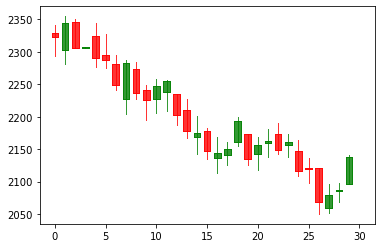

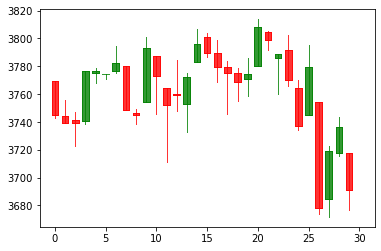

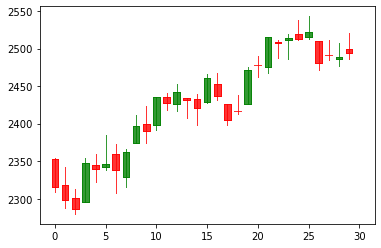

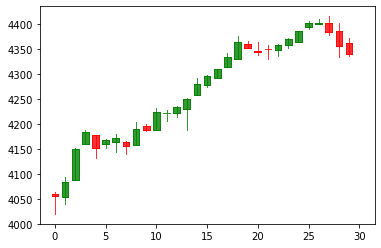

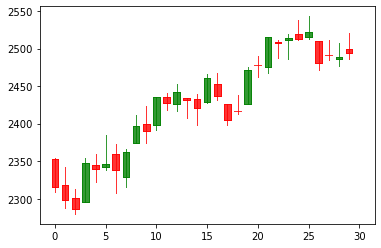

Gráficos con patrón doble suelo etiquetados


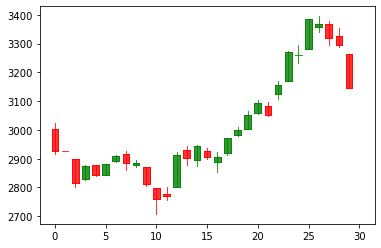

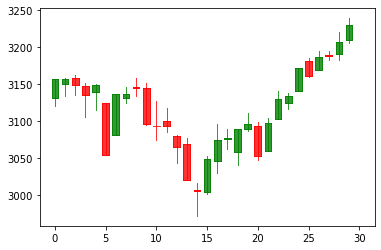

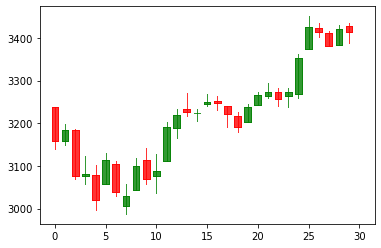

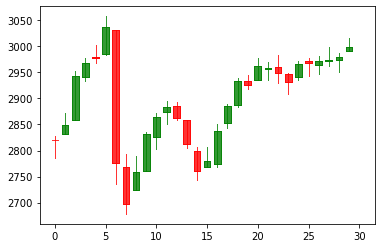

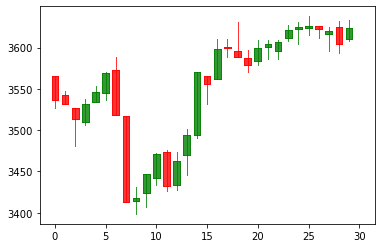

Gráficos con patrón doble techo etiquetados


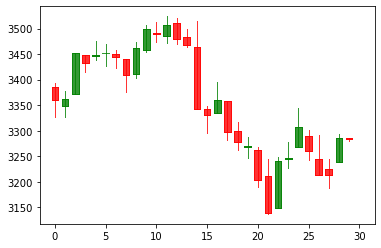

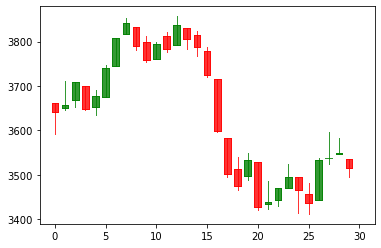

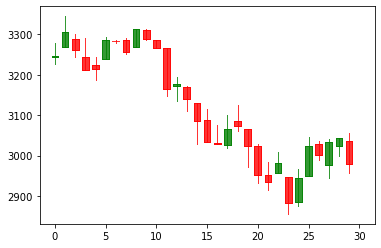

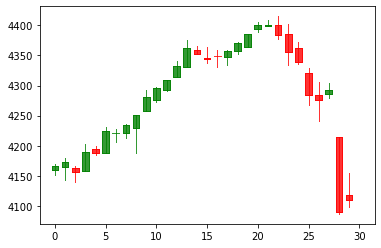

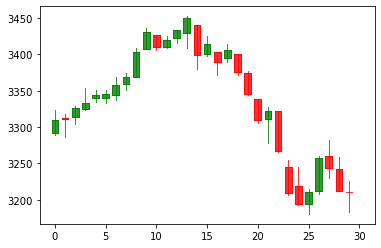

In [118]:
graficos_0 = [etiquetado_stoxx.fecha[0],
              etiquetado_stoxx.fecha[3],
              etiquetado_stoxx.fecha[8],
              etiquetado_stoxx.fecha[7],
              etiquetado_stoxx.fecha[8]
             ]

graficos_1 = [etiquetado_stoxx.fecha[19],
              etiquetado_stoxx.fecha[29],
              etiquetado_stoxx.fecha[45],
              etiquetado_stoxx.fecha[51],
              etiquetado_stoxx.fecha[52]
             ]

graficos_2 = [etiquetado_stoxx.fecha[26],
              etiquetado_stoxx.fecha[28],
              etiquetado_stoxx.fecha[31],
              etiquetado_stoxx.fecha[35],
              etiquetado_stoxx.fecha[42]
             ]
print("Gráficos sin patrón etiquetados")
for i in range(5):
    idx = v[v.fecha == graficos_0[i]].index[0]
    windata = v.iloc[idx:idx+30]
    fig, ax = plt.subplots(figsize=(6,4))
    _ = candlestick2_ohlc(ax, windata.open, windata.high,
                         windata.low, windata.close,
                         colorup='g', colordown='r', width=0.66, alpha=0.8)

    plt.show()

print("Gráficos con patrón doble suelo etiquetados")
for i in range(5):
    idx = v[v.fecha == graficos_1[i]].index[0]
    windata = v.iloc[idx:idx+30]
    fig, ax = plt.subplots(figsize=(6,4))
    _ = candlestick2_ohlc(ax, windata.open, windata.high,
                         windata.low, windata.close,
                         colorup='g', colordown='r', width=0.66, alpha=0.8)

    plt.show()

print("Gráficos con patrón doble techo etiquetados")
for i in range(5):
    idx = v[v.fecha == graficos_2[i]].index[0]
    windata = v.iloc[idx:idx+30]
    fig, ax = plt.subplots(figsize=(6,4))
    _ = candlestick2_ohlc(ax, windata.open, windata.high,
                         windata.low, windata.close,
                         colorup='g', colordown='r', width=0.66, alpha=0.8)

    plt.show()